In [2]:
import pandas as pd
from scipy.stats import skew, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt

file_path = r"C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Predictions_Sample_Data\ENST00000429829.6_predictions.tsv"
df = pd.read_csv(file_path, sep='\t')
df.head()

,rna_index,rna_start,rna_end,dna_index,dna_start,dna_end,HNRNPC,HNRNPK,HNRNPM,MATR3,PTBP1,SRSF1,TIA1
0,50,0,100,73852673,73852623,73852723,0.694644,0.488768,0.301806,0.913165,0.393542,0.366644,0.848362
1,60,10,110,73852663,73852613,73852713,0.508488,0.226550,0.346506,0.859849,0.331914,0.433435,0.663155
2,70,20,120,73852653,73852603,73852703,0.069667,0.251957,0.108793,0.624135,0.230707,0.219274,0.116439
3,80,30,130,73852643,73852593,73852693,0.230525,0.683498,0.082749,0.750837,0.601004,0.257597,0.130026
4,90,40,140,73852633,73852583,73852683,0.374508,0.943981,0.108518,0.918591,0.951651,0.412851,0.491435


In [3]:
# Variables for percentiles, max-min, mean, variance, skew, and kurtosis
proteins = ['HNRNPC', 'HNRNPK', 'HNRNPM', 'MATR3', 'PTBP1', 'SRSF1', 'TIA1']
proportions, max_min, means, variances, skews, kurtoses = {}, {}, {}, {}, {}, {}

# Summary Statistic Feature Extraction
N = 20
for protein in proteins:
    df[f'{protein}_percentile'] = pd.cut(df[protein], bins=[i/N for i in range(N+1)], labels=False, include_lowest=True)
    for i in range(N):
        percentile_data = df[df[f'{protein}_percentile'] == i][protein] - (i / N)
        proportions[f'{protein}_percentile{i}'] = percentile_data.shape[0] / df.shape[0]
        max_min[f'{protein}_percentile{i}_max_min'] = percentile_data.max() - percentile_data.min()
        means[f'{protein}_percentile{i}_mean'] = percentile_data.mean()
        variances[f'{protein}_percentile{i}_variance'] = percentile_data.var()
        skews[f'{protein}_percentile{i}_skew'] = skew(percentile_data)
        kurtoses[f'{protein}_percentile{i}_kurtosis'] = kurtosis(percentile_data)

# Summary Statistics Dataframe
data = {'Protein': proteins}
for i in range(N):
    lower_bound = i / N
    upper_bound = (i + 1) / N
    data[f'({lower_bound:.2f}-{upper_bound:.2f})_Proportion'] = [proportions[f'{protein}_percentile{i}'] for protein in proteins]
    data[f'({lower_bound:.2f}-{upper_bound:.2f})_Max_Min'] = [max_min[f'{protein}_percentile{i}_max_min'] for protein in proteins]
    data[f'({lower_bound:.2f}-{upper_bound:.2f})_Mean'] = [means[f'{protein}_percentile{i}_mean'] for protein in proteins]
    data[f'({lower_bound:.2f}-{upper_bound:.2f})_Variance'] = [variances[f'{protein}_percentile{i}_variance'] for protein in proteins]
    data[f'({lower_bound:.2f}-{upper_bound:.2f})_Skew'] = [skews[f'{protein}_percentile{i}_skew'] for protein in proteins]
    data[f'({lower_bound:.2f}-{upper_bound:.2f})_Kurtosis'] = [kurtoses[f'{protein}_percentile{i}_kurtosis'] for protein in proteins]
result_df = pd.DataFrame(data).fillna(0)
result_df

,Protein,(0.00-0.05)_Proportion,(0.00-0.05)_Max_Min,(0.00-0.05)_Mean,(0.00-0.05)_Variance,(0.00-0.05)_Skew,(0.00-0.05)_Kurtosis,(0.05-0.10)_Proportion,(0.05-0.10)_Max_Min,(0.05-0.10)_Mean,...,(0.90-0.95)_Mean,(0.90-0.95)_Variance,(0.90-0.95)_Skew,(0.90-0.95)_Kurtosis,(0.95-1.00)_Proportion,(0.95-1.00)_Max_Min,(0.95-1.00)_Mean,(0.95-1.00)_Variance,(0.95-1.00)_Skew,(0.95-1.00)_Kurtosis
0,HNRNPC,0.263185,0.047526,0.026481,0.000154,0.071730,-0.973721,0.140992,0.049580,0.022864,...,0.025920,0.000189,-0.267206,-1.142665,0.076240,0.046452,0.020732,0.000185,0.142634,-1.343603
1,HNRNPK,0.320627,0.049665,0.015337,0.000183,0.846699,-0.398091,0.096084,0.049718,0.022185,...,0.026942,0.000184,-0.046733,-1.171179,0.076240,0.047051,0.024987,0.000190,-0.205095,-1.256121
2,HNRNPM,0.350914,0.049788,0.015387,0.000196,0.820371,-0.465589,0.097650,0.049551,0.022147,...,0.031312,0.000164,-0.509934,-0.991651,0.071018,0.048842,0.025458,0.000201,-0.092142,-1.192633
3,MATR3,0.079373,0.049606,0.028374,0.000170,-0.215028,-0.919402,0.061619,0.049278,0.022187,...,0.024935,0.000216,0.203788,-1.238457,0.074674,0.045915,0.022066,0.000159,-0.010917,-0.968210
4,PTBP1,0.183290,0.049621,0.021213,0.000207,0.409171,-1.072641,0.098695,0.049861,0.022614,...,0.025035,0.000208,-0.085604,-0.990113,0.048564,0.048558,0.026150,0.000187,-0.127687,-1.206626
5,SRSF1,0.152480,0.048919,0.022927,0.000194,0.281039,-1.089064,0.107050,0.049510,0.022558,...,0.027437,0.000239,-0.254169,-1.133193,0.019843,0.037339,0.016795,0.000131,0.051548,-1.167818
6,TIA1,0.147258,0.049732,0.027786,0.000164,-0.038431,-1.097162,0.098172,0.049286,0.021362,...,0.028890,0.000189,-0.365204,-1.059640,0.048564,0.045429,0.021161,0.000164,0.351579,-1.097854


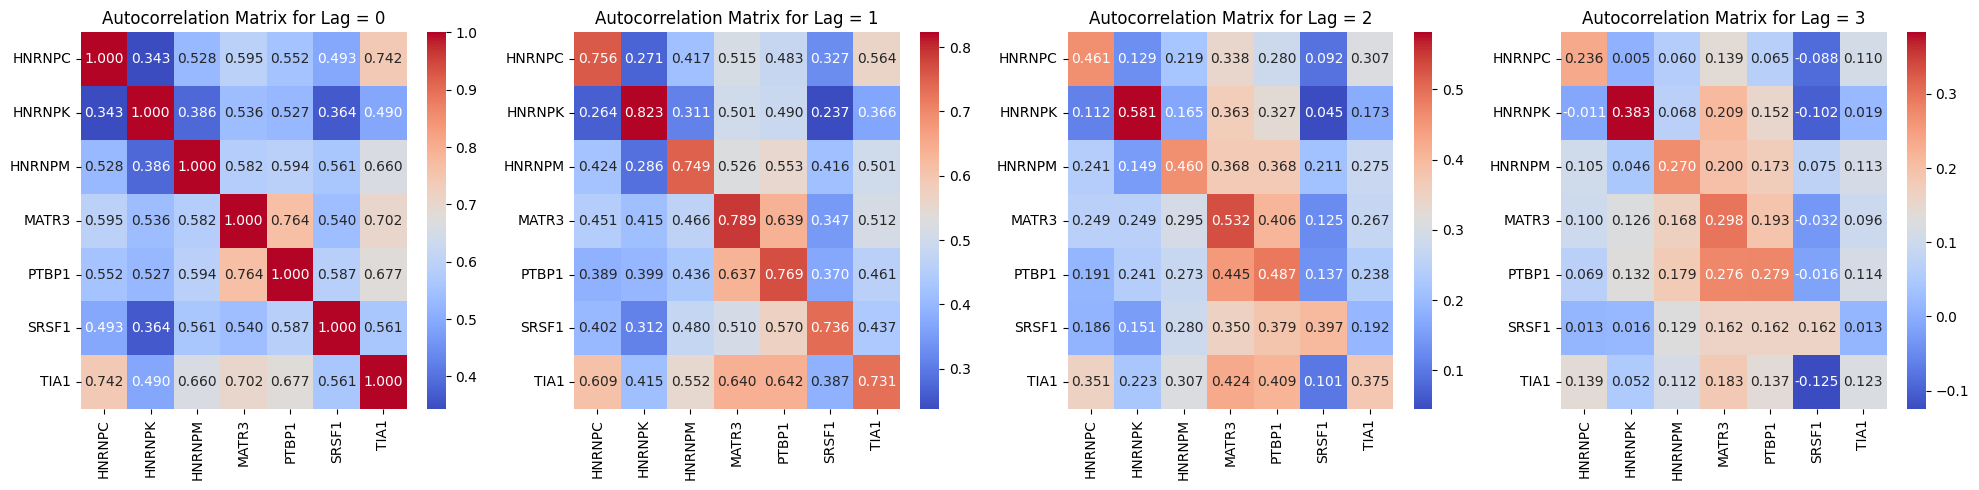

In [4]:
# Auto-correlation Matrices per Lag
lags = [0, 1, 2, 3]
fig, axes = plt.subplots(1, len(lags), figsize=(20, 5))
for idx, L in enumerate(lags):
    autocorrelation_matrix = pd.DataFrame(index=proteins, columns=proteins)
    for protein1 in proteins:
        for protein2 in proteins:
            autocorrelation_matrix.loc[protein1, protein2] = df[protein1].corr(df[protein2].shift(L))
    autocorrelation_matrix = autocorrelation_matrix.astype(float).round(3)
    sns.heatmap(autocorrelation_matrix, annot=True, cmap='coolwarm', fmt='.3f', ax=axes[idx])
    axes[idx].set_title(f'Autocorrelation Matrix for Lag = {L}')
plt.tight_layout()
plt.show()

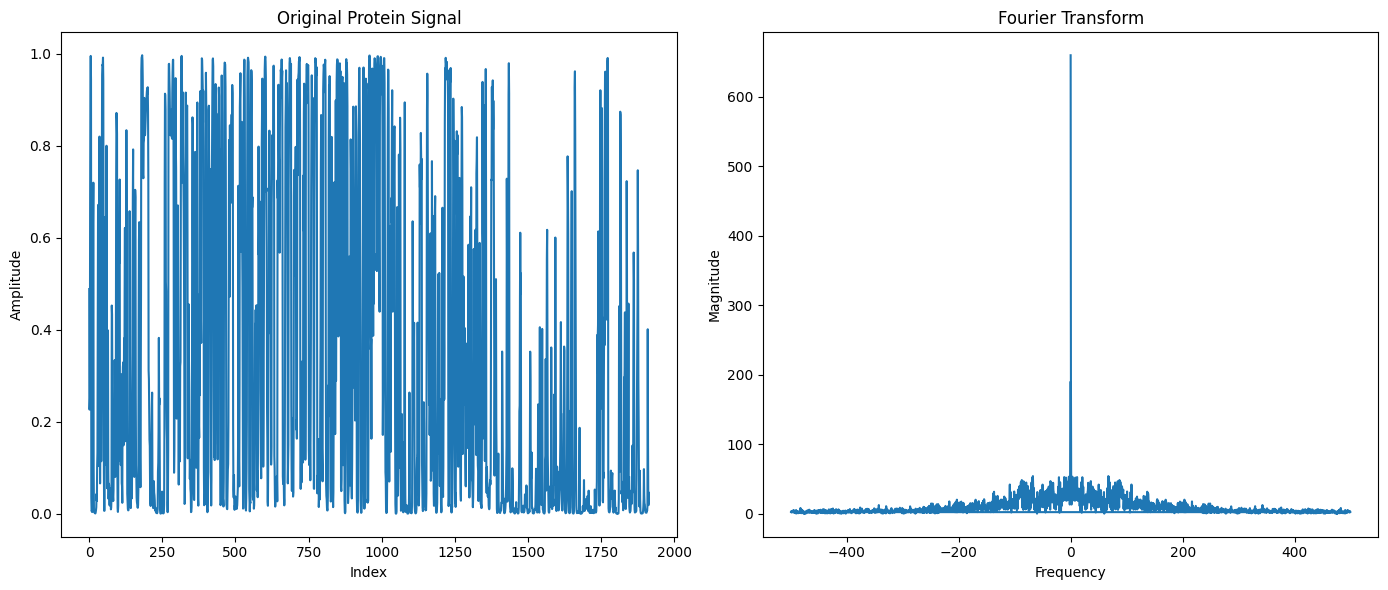

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Select Protein
protein_signal = df['HNRNPK'].values

# Perform Fourier Transform
fft_values = np.fft.fft(protein_signal)
fft_freq = np.fft.fftfreq(len(protein_signal), d=1/1000)
fft_magnitude = np.abs(fft_values)
ifft_values = np.fft.ifft(fft_values)

# Plot the original protein signal
plt.figure(figsize=(21, 6))
plt.subplot(1, 3, 1)
plt.plot(protein_signal)
plt.title('Original Protein Signal')
plt.xlabel('Index')
plt.ylabel('Amplitude')

# Plot the Fourier Transform
plt.subplot(1, 3, 2)
plt.plot(fft_freq, fft_magnitude)
plt.title('Fourier Transform')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
#plt.xlim(0, 50)  # Limit x-axis for better visualization

plt.tight_layout()
plt.show()